# BMM via the changepoint kernel: with mean function choices

## Author: Alexandra Semposki

### Date last edited: 16 January 2025

---

*Need to add information about this code and how it is to be used here.*

In [116]:
# do NOT rerun this cell if running greedy algorithm
new_pts = []

---
---


In [201]:
# define if using mean function or not
mean_function = True

if mean_function is False:
    type_mean = '0'
else:
    type_mean = 'spline'

---

In [202]:
# larger error bars in FRG data
larger_errors = False

---

In [203]:
number = len(new_pts)
print(number)

3


In [204]:
# cutoff parameter moves up here for clarity
cutoff = 40

---

In [205]:
# import needed packages
%load_ext autoreload
%autoreload 2

import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
from scipy.linalg import block_diag
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from custom_kernels import Changepoint
from eos_utils import *
from tov_utils import *
from scripts import *
from pqcd_reworked import PQCD

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Setting up the training data <a id="setup"></a>

Load in the data sets from $\chi$EFT and perturbative QCD.

In [206]:
data_xeft = np.load('../data/NSM_data/chiral_nsm_scaled.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled_NSM.npz')

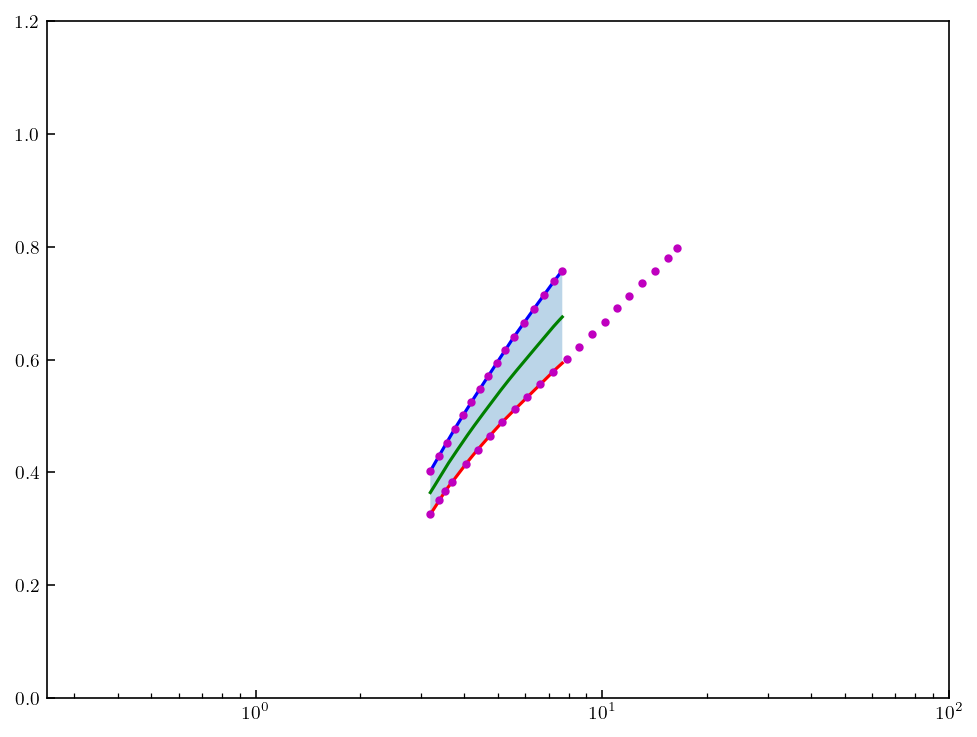

In [207]:
# call frg function
from data_utils import frg_greedy_data
frg_data, lowercontour, uppercontour = frg_greedy_data(plot=True, larger_errors=larger_errors)

In [208]:
# select training points to use 
data_xeft_2 = {
    'density': data_xeft['density'][::2],
    'mean': data_xeft['mean'][::2],
    'std_dev': data_xeft['std_dev'][::2],
    'cov': data_xeft['cov'][::2,::2]
    
}

chiral_tr_data, pqcd_tr_data, training_data_new = gp_data(data_xeft_2, data_pqcd, cutoff, \
                                                          all_orders=False, matter='ANM')

# delete some of the elements to keep some extra points
nope = [0, 4, 6]

# cut these out
chiral_data = {}
chiral_data['dens'] = np.delete(chiral_tr_data['dens'], nope, 0)
chiral_data['mean'] = np.delete(chiral_tr_data['mean'], nope, 0)
chiral_data['std'] = np.delete(chiral_tr_data['std'], nope, 0)
chiral_data['cov'] = np.delete(np.delete(chiral_tr_data['cov'], nope, 0), nope, 1)

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.4, 900)[:-1]

(8,) (8,) (8,) (8, 8)
(8,) (8,) (8,) (8, 8)
(4,) (4,) (4,) (4, 4)
Cov shape: (12, 12)


In [209]:
# make training data out of the first set
chiral_tr_final = {
    'dens': chiral_tr_data['dens'][1::2],
    'mean': chiral_tr_data['mean'][1::2],
    'std': chiral_tr_data['std'][1::2],
    'cov': chiral_tr_data['cov'][1::2,1::2]
}

In [210]:
pqcd_tr_final = {
    'dens': pqcd_tr_data['dens'],
    'mean': pqcd_tr_data['mean'],
    'std': pqcd_tr_data['std'],
    'cov': pqcd_tr_data['cov']
}

# if no mock data, use the original training set with no fRG data included
if len(new_pts) == 0:

    training_data_2 = {
        'dens': np.concatenate((chiral_tr_final['dens'], pqcd_tr_final['dens'])),
        'mean': np.concatenate((chiral_tr_final['mean'], pqcd_tr_final['mean'])),
        'std': np.concatenate((chiral_tr_final['std'], pqcd_tr_final['std'])),
        'cov': block_diag(chiral_tr_final['cov'], pqcd_tr_final['cov'])
    }
    
else:
    print('Using new data set from previous run.')
    training_data_2 = {
        'dens': np.concatenate((chiral_tr_final['dens'], new_pts, pqcd_tr_final['dens'])),
        'mean': np.concatenate((chiral_tr_final['mean'], frg_mean, pqcd_tr_final['mean'])),
        'std': np.concatenate((chiral_tr_final['std'], frg_std, pqcd_tr_final['std'])),
        'cov': block_diag(chiral_tr_final['cov'], frg_cov, pqcd_tr_final['cov'])
    }

# print training data for Table II results
print('\nDensity: \n', training_data_2['dens'])
print('\nMean: \n', training_data_2['mean'])
print('\nStd dev: \n', training_data_2['std'])
print('\nCov: \n', training_data_2['cov'])

Using new data set from previous run.

Density: 
 [ 0.09357262  0.17103506  0.2484975   0.32595993  0.85022247  0.54104561
  1.30489433  6.5736227   9.30317195 12.0327212  14.76227045]

Mean: 
 [0.04384642 0.10521407 0.19189235 0.26642541 0.55171859 0.37861444
 0.68550834 1.09534974 1.0861765  1.0805493  1.07662893]

Std dev: 
 [0.00439573 0.01597702 0.03677041 0.07065512 0.0605438  0.03932216
 0.08269732 0.0192124  0.01519569 0.0129697  0.01152593]

Cov: 
 [[1.93224053e-05 6.39433820e-05 1.20853130e-04 1.82347847e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.39433820e-05 2.55265313e-04 5.55878240e-04 9.36888850e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.20853130e-04 5.55878240e-04 1.35206273e-03 2.49433392e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.82347847e-04 9.368

In [211]:
errorbar_kwargs_2 = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="*",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=8,
)

errorbar_kwargs_frg = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

In [212]:
# chiral EFT data 
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean']
p_stdv_xeft = data_xeft['std_dev']
p_cov_xeft = data_xeft['cov']

# get the pqcd curve to only plot greater than the cutoff choice
ind_cut = np.where(data_pqcd['density']/n0 >= cutoff)[0][0]

# pQCD data
n_pqcd = data_pqcd['density'][ind_cut:]
p_mean_pqcd = data_pqcd['mean'][ind_cut:, -1]
p_stdv_pqcd = data_pqcd['std_dev'][ind_cut:, -1]
p_cov_pqcd = data_pqcd['cov'][ind_cut:, ind_cut:, -1]

# save this for plotting later (uncomment to save)
#np.savez('../data/NSM_data/pressure_pqcd_cut_20_NSM.npz', dens=n_pqcd, mean=p_mean_pqcd, std=p_stdv_pqcd)

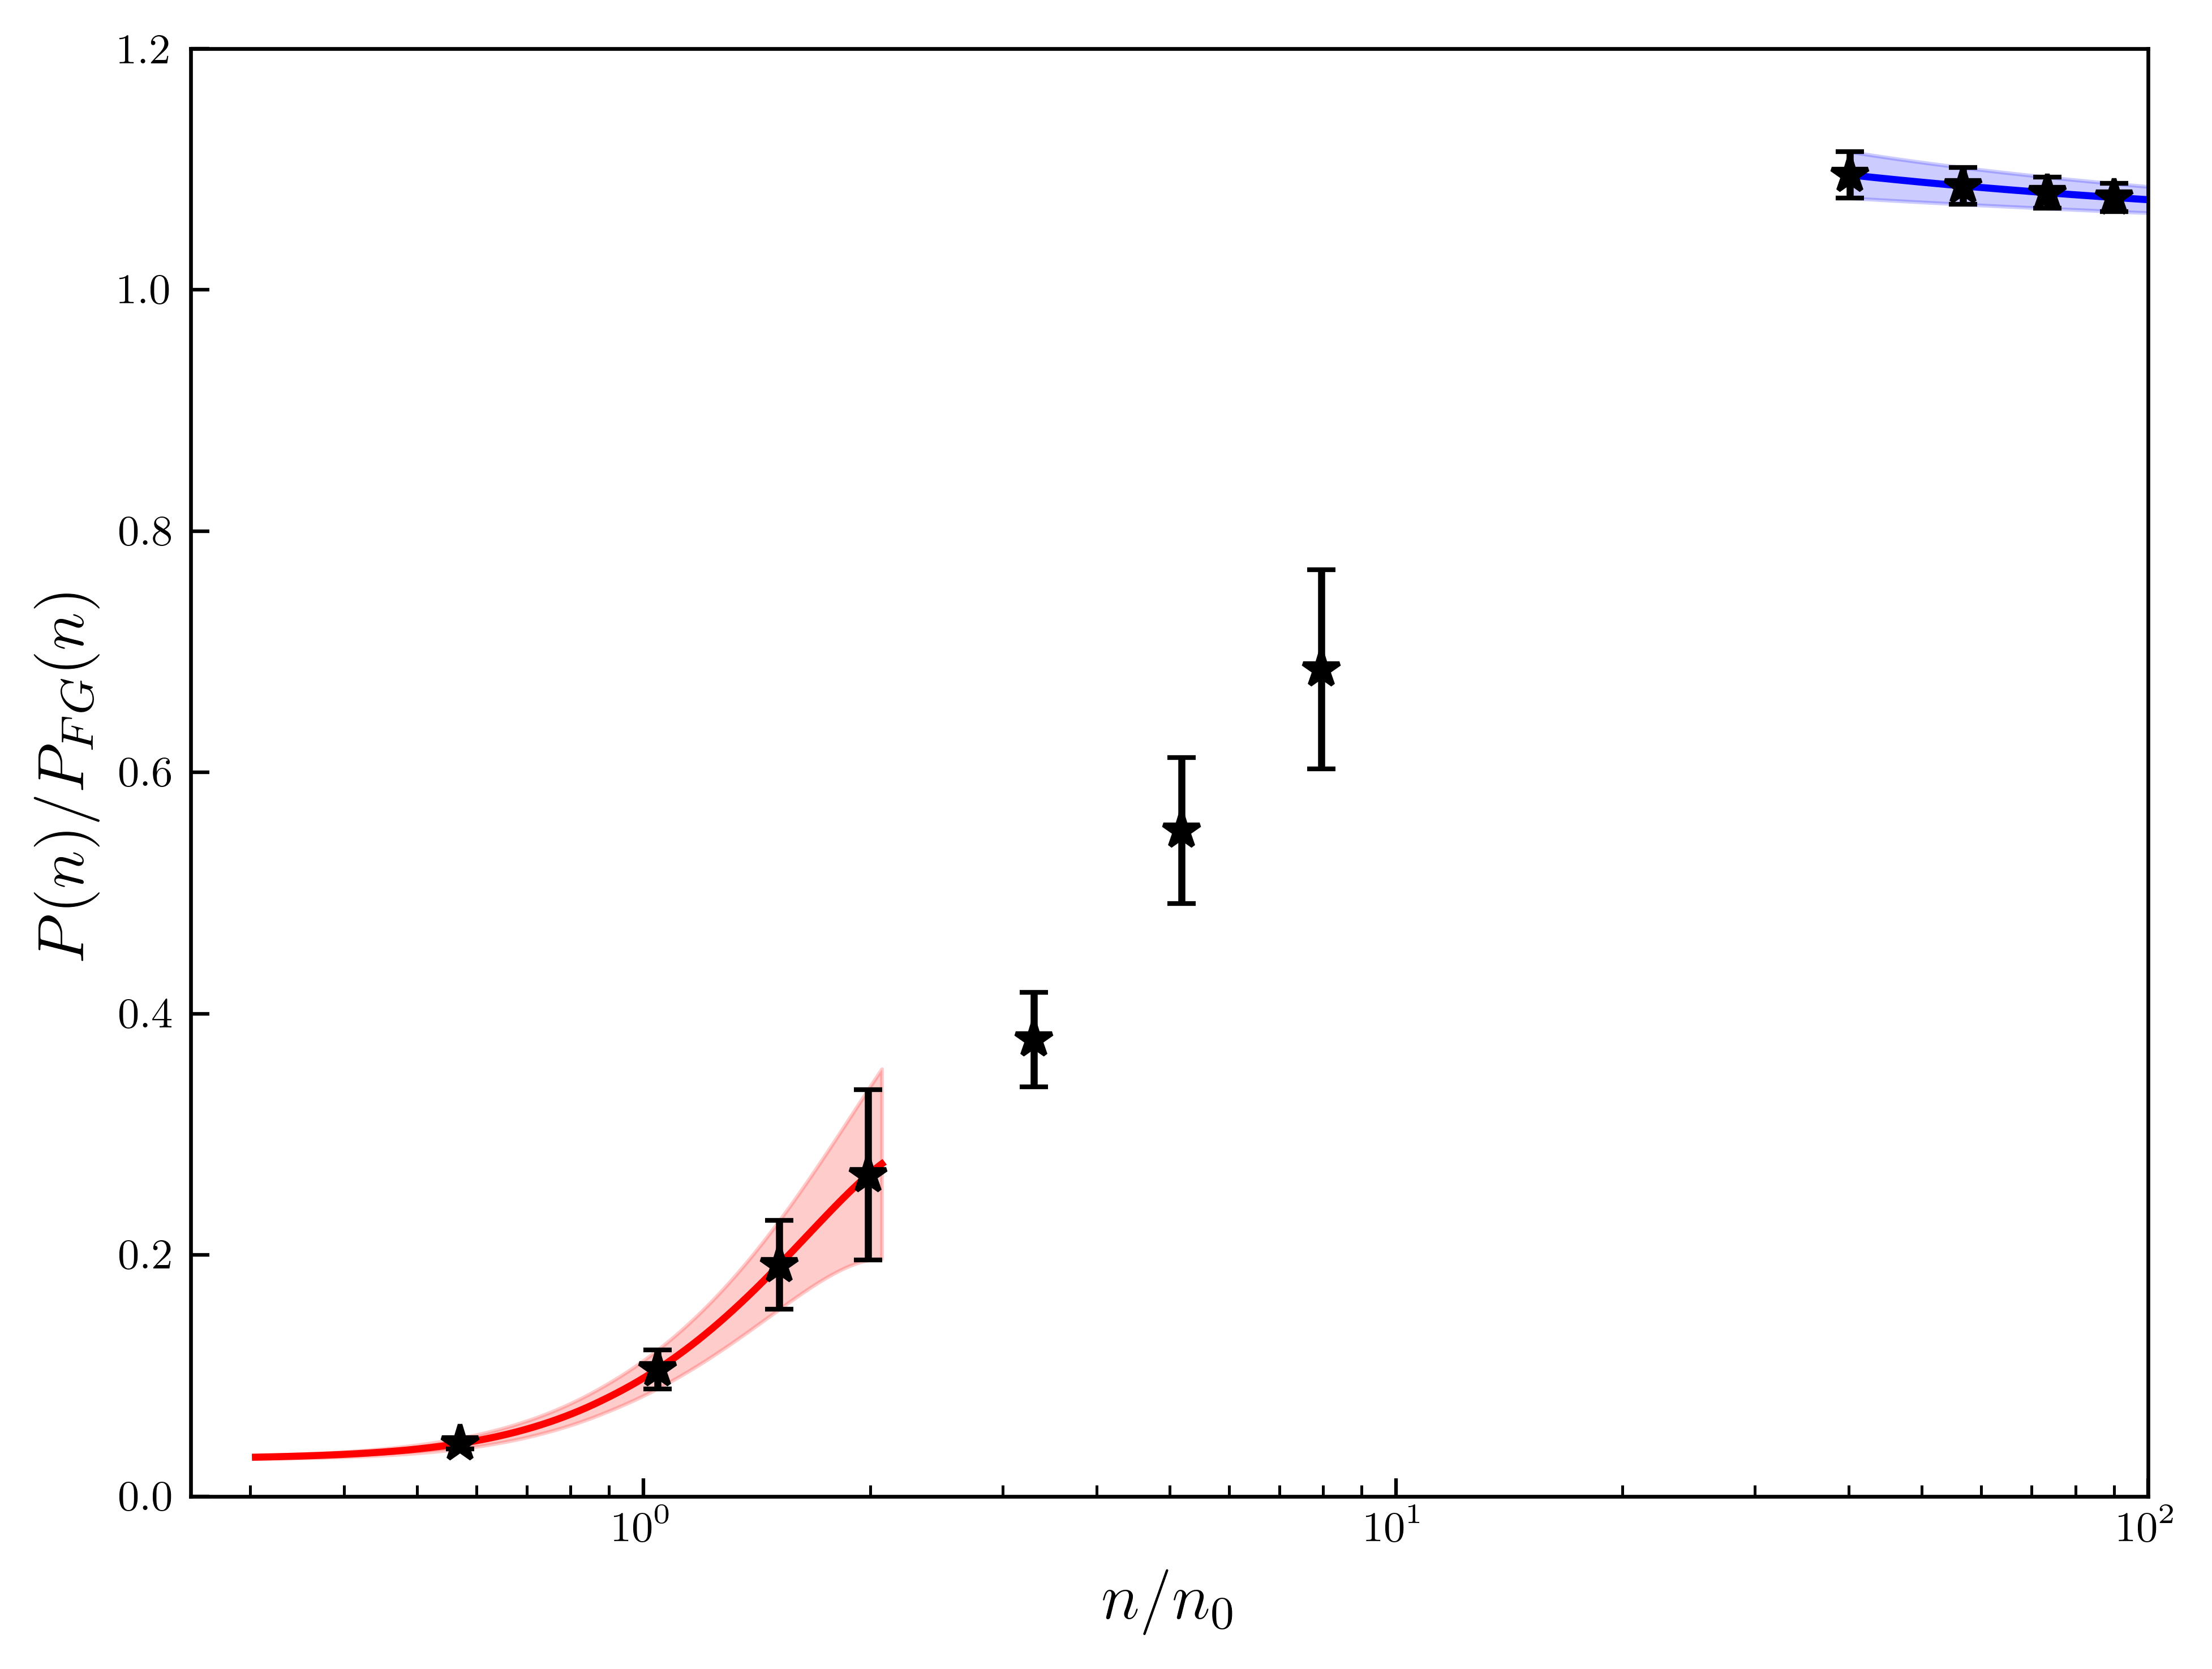

In [213]:
# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft = "red"
color_xeft_2 = 'green'
color_pqcd = "blue"
ax.set_xlim(0.25, 100.0)
ax.set_ylim(0, 1.2)
ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)

# result of idea 1
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)

ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)

# ax.plot(df_frg['n/n0'], 0.94*df_frg['P/P_free'], color='m', marker='.', linestyle=' ', \
#            zorder=10, label='Leonhardt et al. (2020)')

# new data for the fRG mock data contour
# ax.errorbar(x=n_frg/n0, y=p_mean_frg, yerr=p_std_frg, \
#             **errorbar_kwargs_2)

plt.show()

In [214]:
# data to save here for this sigma test
# frg_dens = training_data_2['dens']
# frg_mean = training_data_2['mean']
# frg_std = training_data_2['std']
# frg_cov = training_data_2['cov']

## Mean function choices

Here we wish to design a mean function that will help us test whether the choice of the mean function affects our overall result when training on FRG data in the intermediate region.

[0.5410456062291434, 0.850222469410456, 1.3048943270300333] [0.3786144403375665, 0.5517185920076365, 0.6855083393305383]


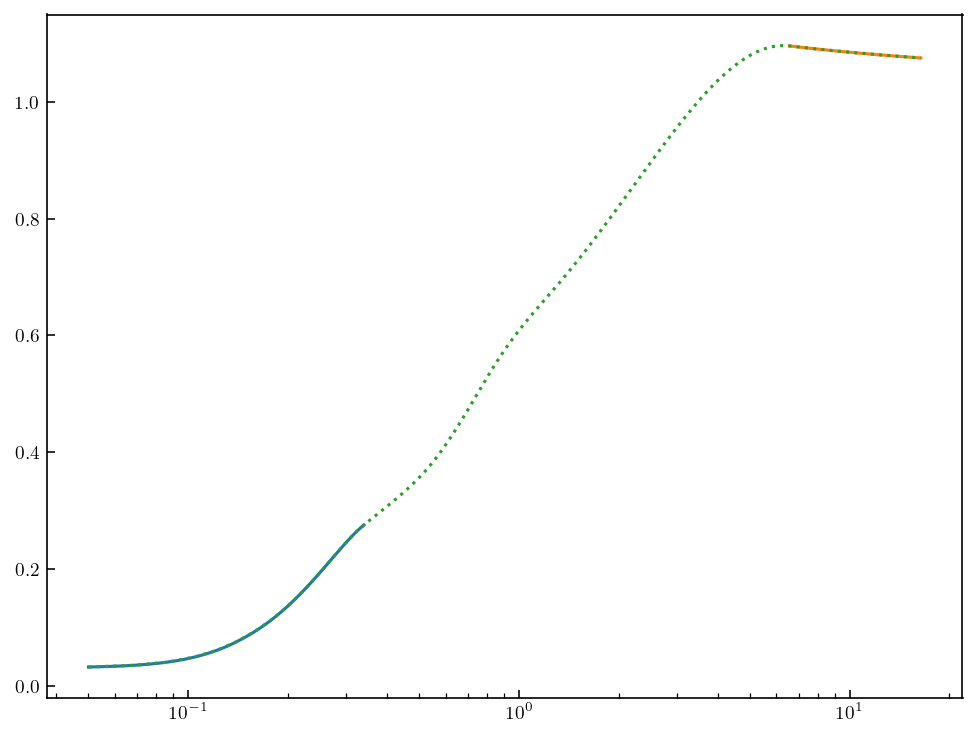

In [215]:
if mean_function is True:
    
    # make necessary data sets
    from data_utils import log_full_cubic_spline
    
    if len(new_pts) == 0:
        total_dens = np.concatenate((n_xeft, n_pqcd))
        total_data = np.concatenate((p_mean_xeft, p_mean_pqcd))
    else:
        total_dens = np.concatenate((n_xeft, sorted_frg_dens, n_pqcd))
        total_data = np.concatenate((p_mean_xeft, sorted_frg_mean, p_mean_pqcd))
        print(sorted_frg_dens, sorted_frg_mean)

    # create scaled data here
    y_scaled = training_data_2['mean'] - np.exp(log_full_cubic_spline(total_dens, \
                                                                      total_data, training_data_2['dens']))

    # test via plotting
    plt.plot(n_xeft, p_mean_xeft)
    plt.plot(n_pqcd, p_mean_pqcd)
    plt.plot(density_test, np.exp(log_full_cubic_spline(total_dens, \
                                                        total_data, density_test)), linestyle='dotted')
    plt.xscale('log')

## Calculation of $P(n)$ using a changepoint kernel  <a id="calc_p_n"></a>

Now we construct the kernel we wish to use, which is the changepoint kernel. 

$$
k(x_i, x_j) = (1 - \sigma(x_i)) k_{1}(x_i,x_j) (1 - \sigma(x_j)) + \sigma(x_i) k_{2}(x_i, x_j) \sigma(x_j),
$$

where, for our initial test case, $k_{1}$, $k_{2}$ are the RBF kernel, and $\sigma$ are sigmoid functions, given as

$$
\sigma(x) = \frac{1}{1 + \exp(-k(x-x_{c})}.
$$ 


The changepoint is determined within the sigmoid function as $x_{c}$, along with a width parameter $k$ that will describe the slope of the function about the changepoint location. These are two parameters that will need to be optimized in the full training of the kernel---we will be attempting this after fixing them and testing that scenario first. The RBF kernels will both be trained on the individual data in each region, and let extrapolate until the changepoint.

This will first be coded manually and checked for accuracy, then will be coded into the `sklearn` workflow.

0.949**2 * RBF(length_scale=0.328)


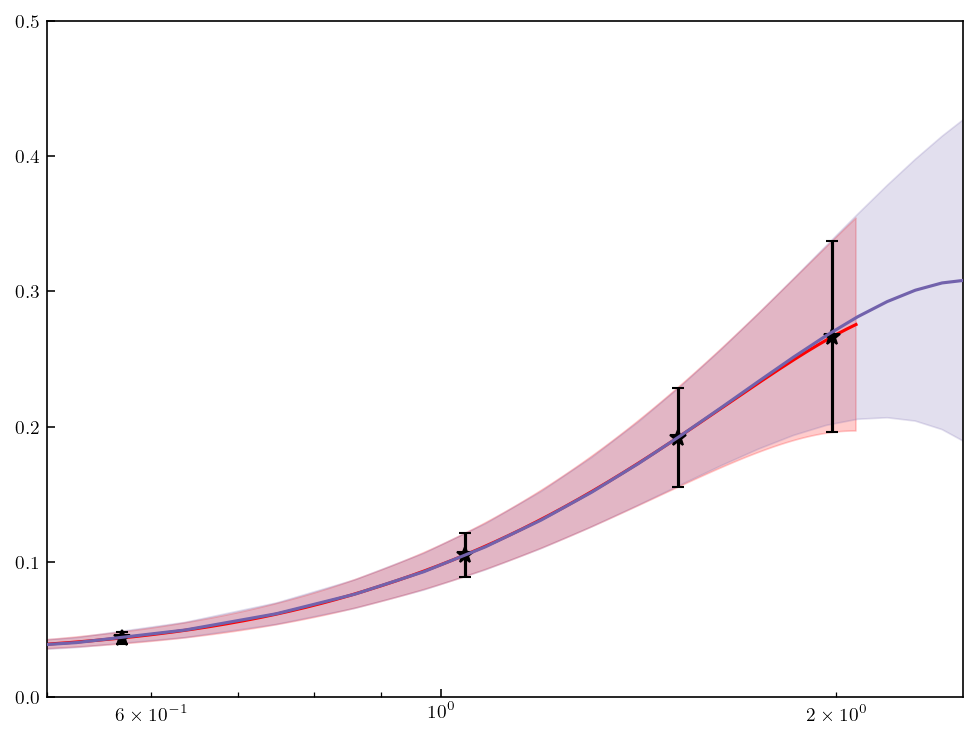

% error at 2n0:  3.75


In [216]:
# trial and error optimal length scales and variances (expand to variable quantities?)
k_chi = (C(constant_value=0.9, constant_value_bounds='fixed') \
         * RBF(length_scale=0.328, length_scale_bounds='fixed'))

# chiral EFT
gp = GaussianProcessRegressor2dNoise(
    kernel=k_chi,
    alpha = chiral_tr_final['cov'],
)

gp.fit(chiral_tr_final['dens'].reshape(-1,1), chiral_tr_final['mean'].reshape(-1,1))

print(gp.kernel_)

chi_predict, chi_std_predict = gp.predict(density_test.reshape(-1,1), return_std=True)
_, chi_cov_predict = gp.predict(density_test.reshape(-1,1), return_cov=True)

# plot the result quickly to test
plt.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
plt.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.plot(density_test/n0, chi_predict, color=colors[2], zorder=10)
plt.fill_between(density_test/n0, chi_predict-chi_std_predict, chi_predict+chi_std_predict, \
                 color=colors[2], alpha=0.2)
plt.ylim(0.0, 0.5)
plt.xlim(0.5, 2.5)
plt.xscale('log')
plt.show()

# check standard deviation difference at 2*n0 or so
dens_band = n_xeft[-1]
std_band = p_stdv_xeft[-1]
ind_chi = np.where([density_test[i] > 0.34 for i in range(len(density_test))])[0][0]
gp_band = chi_std_predict[ind_chi]

print('% error at 2n0: ', round((std_band - gp_band)/std_band*100, 2))

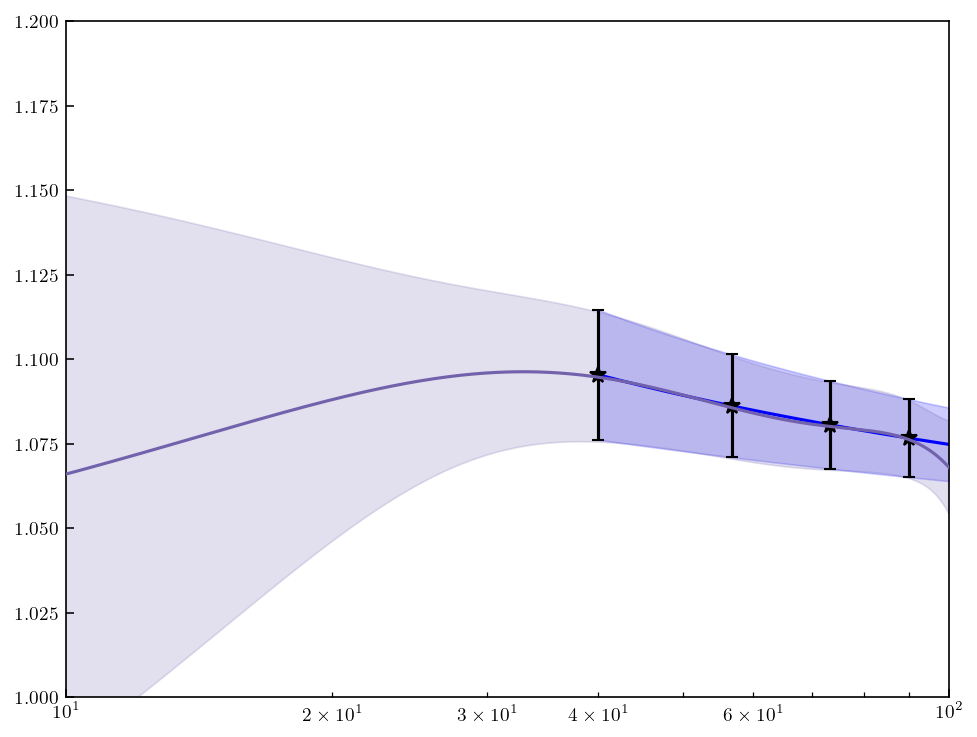

In [217]:
# now we're going to attempt to fit pQCD
if cutoff == 20:
    k_pqcd = (C(constant_value=1.0, constant_value_bounds='fixed') \
              * RBF(length_scale=6.5, length_scale_bounds='fixed'))
elif cutoff == 40:
    k_pqcd = (C(constant_value=1.0, constant_value_bounds='fixed') \
              * RBF(length_scale=10.0, length_scale_bounds='fixed'))

# chiral EFT
gp2 = GaussianProcessRegressor2dNoise(
    kernel=k_pqcd,
    alpha = pqcd_tr_final['cov'],
)

gp2.fit(pqcd_tr_final['dens'].reshape(-1,1), pqcd_tr_final['mean'].reshape(-1,1), priors=False, \
        prior_choice='truncnorm_15')

pqcd_predict, pqcd_std_predict = gp2.predict(density_test.reshape(-1,1), return_std=True)
_, pqcd_cov_predict = gp2.predict(density_test.reshape(-1,1), return_cov=True)

# plot the result quickly to test
plt.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
plt.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.plot(density_test/n0, pqcd_predict, color=colors[2], zorder=10)
plt.fill_between(density_test/n0, pqcd_predict-pqcd_std_predict, pqcd_predict+pqcd_std_predict, \
                 color=colors[2], alpha=0.2)
plt.ylim(1.0, 1.2)
plt.xlim(10.0, 100.0)
plt.xscale('log')
plt.show()

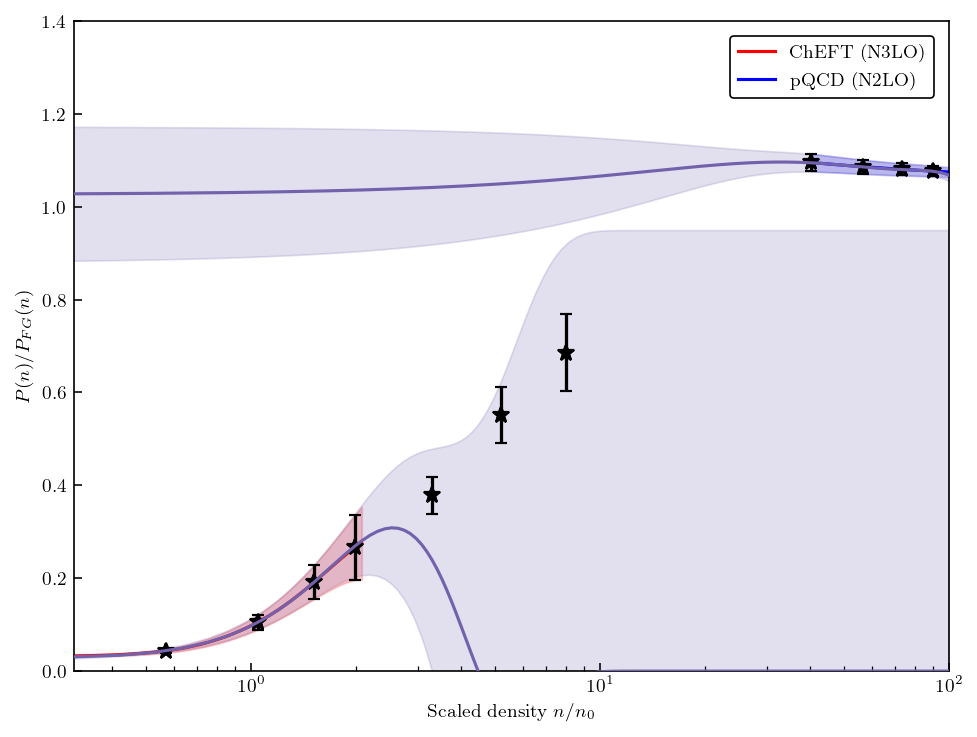

In [218]:
# check the plotting of both of these together, see what they look like
plt.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
plt.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.plot(density_test/n0, chi_predict, color=colors[2], zorder=10)
plt.fill_between(density_test/n0, chi_predict-chi_std_predict, chi_predict+chi_std_predict, \
                 color=colors[2], alpha=0.2)
plt.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
plt.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.plot(density_test/n0, pqcd_predict, color=colors[2], zorder=10)
plt.fill_between(density_test/n0, pqcd_predict-pqcd_std_predict, \
                 pqcd_predict+pqcd_std_predict, color=colors[2], alpha=0.2)
plt.ylim(0.0, 1.4)
plt.xlim(0.31, 100.0)
plt.xscale('log')
plt.legend()
plt.xlabel(r'Scaled density $n/n_0$')
plt.ylabel(r'$P(n)/P_{FG}(n)$')
plt.show()

### BMM using a changepoint kernel with a theta function

In [219]:
# we've implemented it in the kernel section, so let's try it out
from custom_kernels import Changepoint

# kernel
if cutoff == 20:
    kernel = Changepoint(ls1=0.328, ls2=6.5, cbar1=0.9, cbar2=1.0, changepoint=0.9, \
                         changepoint_bounds=[0.488, 3.12], width=0.16, width_bounds=[0.05, 0.32])  # 1.476
elif cutoff == 40:
    kernel = Changepoint(ls1=0.328, ls2=10.0, cbar1=0.9, cbar2=1.0, changepoint=0.9, \
                         changepoint_bounds=[0.488, 6.24], width=0.16, width_bounds=[0.05, 0.32])  # 1.476

# set up the GPR object
gpcp = GaussianProcessRegressor2dNoise(kernel=kernel, alpha=training_data_2['cov'] , 
                                       n_restarts_optimizer=10000)
print(cutoff)

40


In [220]:
# train the kernel (though we really don't need to, we need to fit)
X_train = training_data_2['dens'].reshape(-1,1)

if mean_function is True:
    y_train = y_scaled.reshape(-1,1)
else:
    y_train = training_data_2['mean'].reshape(-1,1)

# eliminate nan values from pqcd
# pqcd_dens = data_pqcd['density'][5:]
# pqcd_mean = data_pqcd['mean'][5:]
# pqcd_std = data_pqcd['std_dev'][5:]
# pqcd_cov = data_pqcd['cov'][5:,5:]

# data_cut_pqcd = {
#     'density': pqcd_dens,
#     'mean': pqcd_mean[:,2],
#     'std': pqcd_std[:,2],
#     'cov': pqcd_cov[:2,:2]
# }

prior_dict = {
    'w': 'truncnorm',
    'cp': 'truncnorm'
}
gpcp.fit(X_train, y_train, priors=True, prior_choice='changepoint', prior_type = prior_dict, cutoff=cutoff)
print(gpcp.kernel_)

Changepoint(changepoint=0.49, width=0.178)


Value of maximum likelihood changepoint: 0.33
Value from the GP regression: 0.49


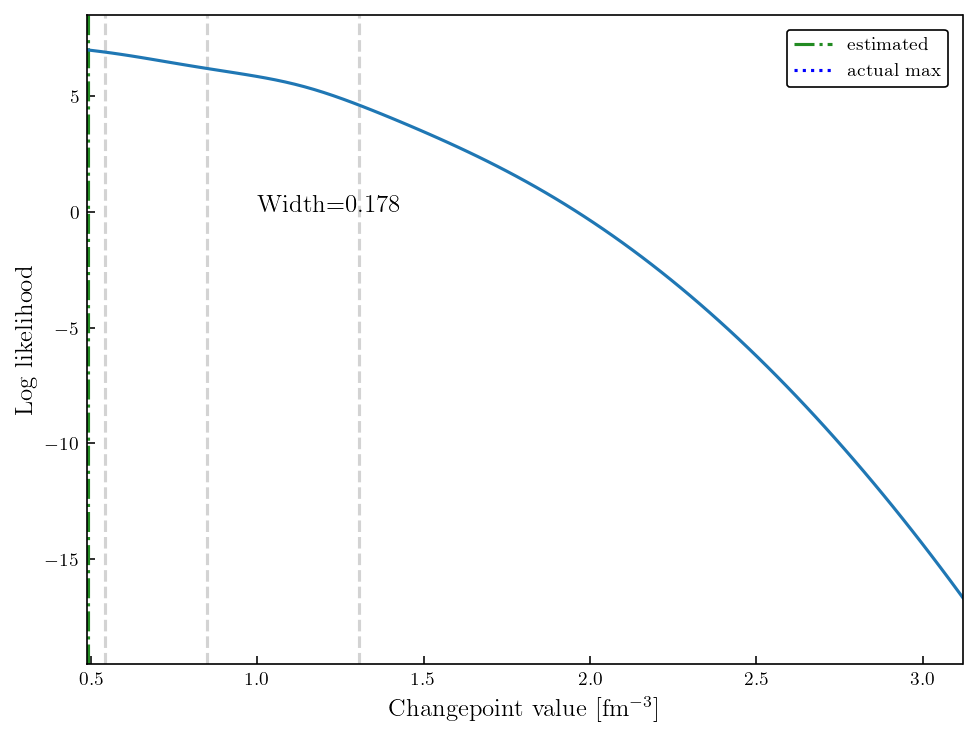

In [221]:
log_likelihood = []
test_cp = np.linspace(0.33, 3.2, 100)
width= round(np.exp(gpcp.kernel_.theta[1]), 3)

for cp in test_cp:
    kernel = Changepoint(ls1=0.328, ls2=6.5, cbar1=0.9, cbar2=1.0, 
                     changepoint=cp, changepoint_bounds=[cp-0.0001, cp+0.0001], \
                         width=width, width_bounds='fixed')  
    gpcptest = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov']  # here is where we input the full covariance matrix from the data
    )
    gpcptest.fit(X_train, y_train, priors=True, prior_choice='changepoint', \
                 prior_type=prior_dict, cutoff=cutoff)
    log_likelihood.append(gpcptest.log_marginal_likelihood())
    
ind = np.where([np.asarray(log_likelihood[i]) >= max(log_likelihood) \
                for i in range(len(log_likelihood))])[0][-1]
cp_final = round(np.exp(gpcp.kernel_.theta[0]), 3)
w_final = round(np.exp(gpcp.kernel_.theta[1]), 3)

# print some values to check
print('Value of maximum likelihood changepoint: {}'.format(test_cp[ind]))
print('Value from the GP regression: {}'.format(cp_final))  # this looks great

#plt.xscale('log')
[plt.axvline(x=training_data_2['dens'][i], linestyle='dashed', color='lightgray') \
 for i in range(len(training_data_2['dens']))]
plt.axvline(x=cp_final, linestyle='-.', label='estimated', color='forestgreen')  
# plot the changepoint result
plt.plot(test_cp, log_likelihood)
plt.axvline(x=test_cp[ind], linestyle='dotted', label=r'actual max', color='blue')

# rest of plot
plt.xlabel(r'Changepoint value [fm$^{-3}$]', fontsize=12)
plt.xlim(0.488, 3.12)
plt.text(1.0, 0.0, 'Width={}'.format(width), fontsize=12)
plt.ylabel('Log likelihood', fontsize=12)
plt.legend()

Value of width at maximum log likelihood: 0.20207070707070707
Value from regression: 0.178


Text(0, 0.5, 'Log likelihood')

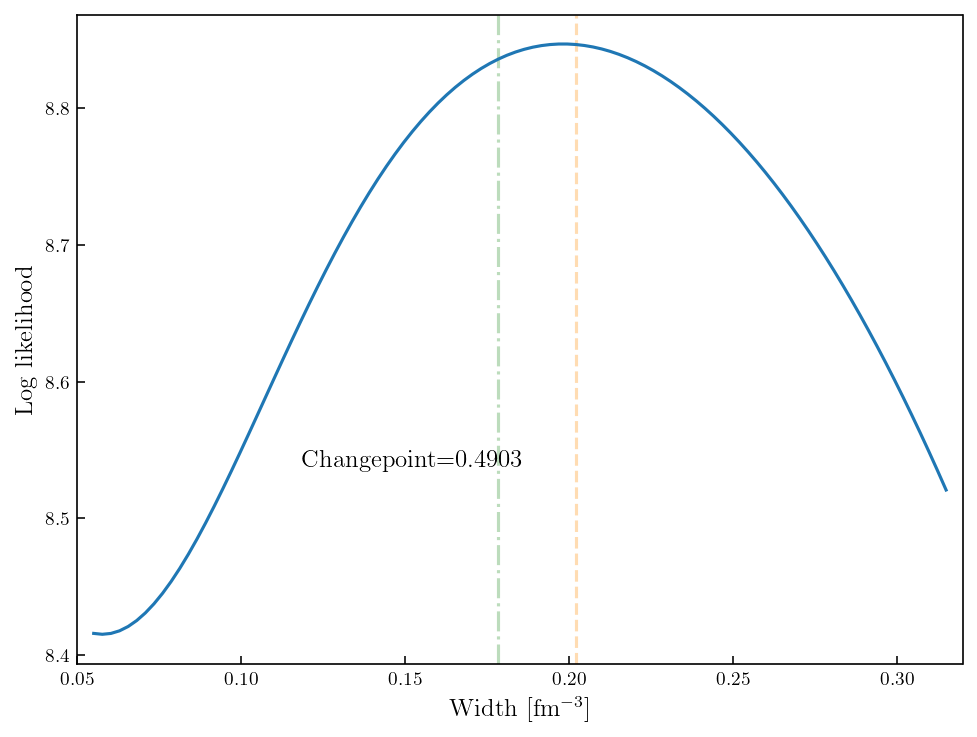

In [222]:
log_likelihood = []
test_w = np.linspace(0.055, 0.315, 100)
chp = np.exp(gpcp.kernel_.theta[0])

for w in test_w:
    kernel = Changepoint(ls1=0.328, ls2=6.5, cbar1=0.9, cbar2=1.0, 
                     changepoint=chp, changepoint_bounds='fixed', width=w, \
                         width_bounds=[w-0.0001, w+0.0001])
    gpcptest2 = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov']  # here is where we input the full covariance matrix from the data
    )
    gpcptest2.fit(X_train, y_train, priors=True, prior_choice='changepoint', \
                  prior_type=prior_dict, cutoff=cutoff)
    log_likelihood.append(gpcptest2.log_marginal_likelihood())
    
ind = np.where([np.asarray(log_likelihood[i]) >= max(log_likelihood) \
                for i in range(len(log_likelihood))])[0][-1]+1

print('Value of width at maximum log likelihood:', test_w[ind])
print('Value from regression:', w_final)

cp_final = round(np.exp(gpcp.kernel_.theta[0]), 4)
w_final = round(np.exp(gpcp.kernel_.theta[1]), 4)

plt.axvline(x=test_w[ind], linestyle='dashed', color='darkorange', alpha=0.3)
plt.axvline(x=w_final, linestyle='-.', color='forestgreen', alpha=0.3)   # plot the changepoint result
plt.plot(test_w, log_likelihood)
plt.xlabel(r'Width [fm$^{-3}$]', fontsize=12)
plt.xlim(0.05, 0.32)
plt.text(0., 0., 'Changepoint={}'.format(cp_final), fontsize=12, transform=ax.transAxes)
plt.ylabel('Log likelihood', fontsize=12)

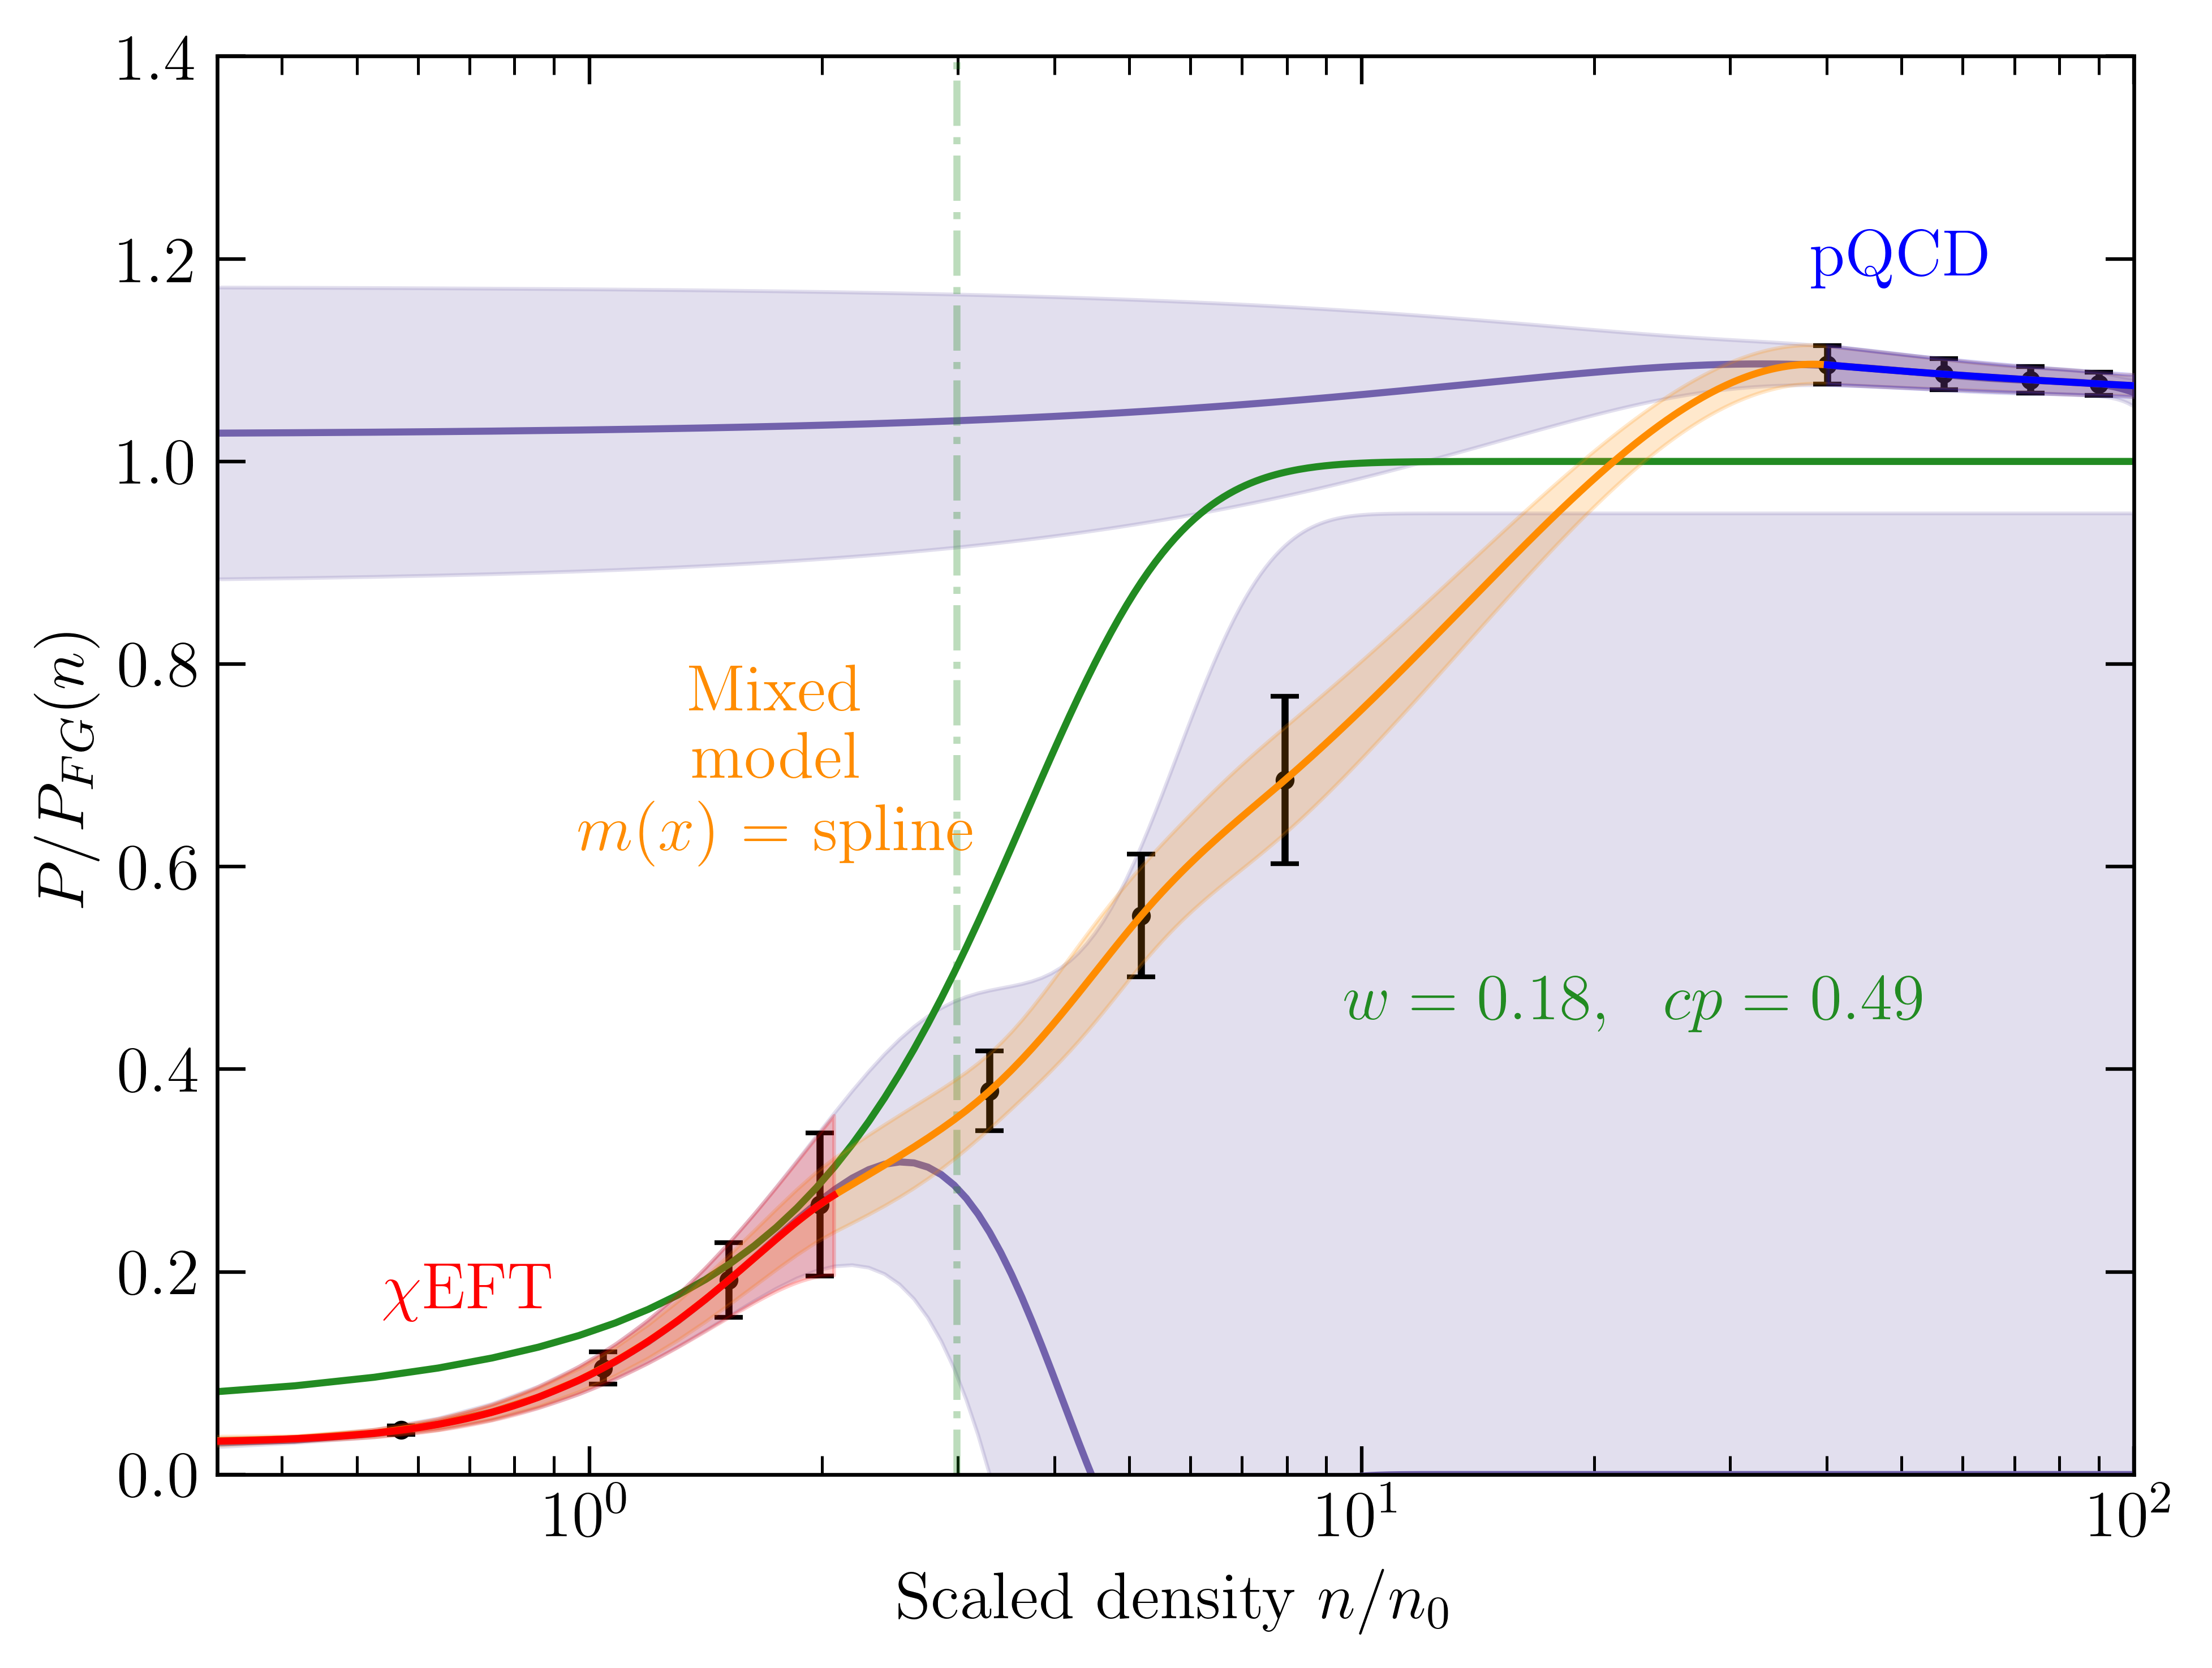

In [223]:
# try predicting with this kernel
X = density_test.reshape(-1,1)

# prediction
y_pred_0, y_stdv_0 = gpcp.predict(X, return_std=True)

if mean_function is True:
    y_pred_0_scaled = y_pred_0 + np.exp(log_full_cubic_spline(total_dens, total_data, x_select=density_test))
else: 
    y_pred_0_scaled = y_pred_0

# plot the result
fig, ax = plt.subplots(1,1, dpi=600)

# check the plotting of both of these together, see what they look like
ax.tick_params(which='major', labelsize=14, right=True, top=True, length=6)
ax.tick_params(which='minor', right=True, top=True, length=4)
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)', zorder=10)
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft, zorder=9)
ax.plot(density_test/n0, chi_predict, color=colors[2])
ax.fill_between(density_test/n0, chi_predict-chi_std_predict, chi_predict+chi_std_predict, \
                 color=colors[2], alpha=0.2)
ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)', zorder=10)
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd, \
                zorder=9)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_frg)
ax.plot(density_test/n0, pqcd_predict, color=colors[2])
ax.fill_between(density_test/n0, pqcd_predict-pqcd_std_predict, \
                 pqcd_predict+pqcd_std_predict, color=colors[2], alpha=0.2)
ax.plot(X[:,0]/n0, y_pred_0_scaled, color='darkorange', zorder=8)
ax.fill_between(X[:,0]/n0, y_pred_0_scaled-y_stdv_0, \
                 y_pred_0_scaled+y_stdv_0, alpha=0.2, color='darkorange', zorder=7)
# ax.fill_between(X[:,0]/n0, y_pred_0_scaled-1.96*y_stdv_0, \
#                  y_pred_0_scaled+1.96*y_stdv_0, alpha=0.1, color='darkorange', zorder=7)

# changepoint location
cp_final = round(np.exp(gpcp.kernel_.theta[0]), 2)
w_final = round(np.exp(gpcp.kernel_.theta[1]), 2)

# plot this
ax.plot(density_test/n0, (1.0 / (1.0 + np.exp(-(density_test-cp_final)/w_final))), color='forestgreen')
ax.text(9.5, 0.45, r'$w={},~~cp={}$'.format(w_final, cp_final),\
        color='forestgreen', fontsize=14)
ax.axvline(x=cp_final/n0, linestyle='-.', color='forestgreen', alpha=0.3)   # plot the changepoint result

# some labelling for fun times
ax.text(0.7, 0.18, r'$\chi$EFT', va='center', ha='center', fontsize=14, color='red')
ax.text(50.0, 1.2, r'pQCD', va='center', ha='center', fontsize=14, color='blue')
ax.text(1.75, 0.7, r'''Mixed 
model
$m(x)$ = {}'''.format(type_mean), va='center', ha='center', \
        multialignment='center', fontsize=14, color='darkorange')

# other things
ax.set_xscale('log')
ax.set_xlabel('Scaled density $n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P/P_{FG}(n)$', fontsize=14)
ax.set_xlim(0.33, 100.0)
ax.set_ylim(0.0, 1.4)
fig.savefig('GIF_plots_Greedy/Mean_function/Plot_FRG_{}_{}_{}.png'.format(cutoff, \
                                                                                     number, mean_function))
plt.show()

In [224]:
# value of the pressure at the same point as the FRG one that is in tension
# ind_pres = np.where([density_test[i] <= frg_dens[7] for i in range(len(density_test))])[0][-1]
# print('Scaled pressure here: ', y_pred_0[ind_pres], 'and std dev: ', y_stdv_0[ind_pres])

# # calculate the number of sigma different the two calculations are
# sigma = np.abs(y_pred_0[ind_pres] - frg_mean[7]) / np.sqrt(frg_std[7]**2.0 + y_stdv_0[ind_pres]**2.0)
# print(sigma)

### Adding mock fRG data based on greedy algorithms

In [225]:
if len(new_pts) !=3 :
    # find the largest error
    max_arr_envelope = max(2.0 * y_stdv_0)
    ind_max_arr = np.where([max_arr_envelope <= 2.0 * y_stdv_0[i] for i in range(len(y_stdv_0))])[0][0]
    print('Largest error location: ', density_test[ind_max_arr]/n0)

    # use this location for the next point in fRG data 
    if density_test[ind_max_arr] not in np.asarray(new_pts):
        new_pts.append(density_test[ind_max_arr])
    else:
        pass
    uppercontourgrid = uppercontour(np.asarray(new_pts)/n0)
    lowercontourgrid = lowercontour(np.asarray(new_pts)/n0)

    # add to the dict (rerun all generations of means, stds, not time consuming)
    frg_mean = np.zeros(len(new_pts))
    frg_std = np.zeros(len(new_pts))
    frg_cov = np.zeros([len(new_pts), len(new_pts)])

    if larger_errors is True:
        std_last = frg_data['std'][-1]
        # use it for every value in the set
        frg_std = std_last*np.ones(len(new_pts))

    for i in range(len(new_pts)):
        frg_mean[i] = (lowercontourgrid[i] + uppercontourgrid[i])/2.0
        if larger_errors is False:
            frg_std[i] = (uppercontourgrid[i]-lowercontourgrid[i])/2.0
        frg_cov[i,i] = np.square(frg_std[i])

    # sort the points in ascending order for the spline later on (density and mean) (will always be ascending)
    sorted_frg_dens = sorted(new_pts)
    sorted_frg_mean = sorted(frg_mean.tolist())

    # check values here
    print('Density: ', sorted_frg_dens, 'and mean: ', sorted_frg_mean)

In [226]:
# plot the unscaled version of the pressure here
convert_pqcd = np.load('../data/eos_data/pqcd_fg_data_NSM.npz')
print(min(convert_pqcd['density']), max(convert_pqcd['density']))

# interpolate for a functional form to use 
convert_interp = sp.interpolate.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
gp_cs2_convert_arr = convert_interp(density_test)

# do this conversion for the data
data_convert_arr = convert_interp(n_xeft)
data_pqcd_convert_arr = convert_interp(n_pqcd)

0.05 16.4


In [227]:
# mixed model
unscaled_data_scaled = gp_cs2_convert_arr * y_pred_0_scaled
unscaled_std = gp_cs2_convert_arr * y_stdv_0

# chiral EFT
unscaled_chi_data = data_convert_arr * p_mean_xeft
unscaled_chi_std = data_convert_arr * p_stdv_xeft

# pQCD
unscaled_pqcd_data = data_pqcd_convert_arr * p_mean_pqcd
unscaled_pqcd_std = data_pqcd_convert_arr * p_stdv_pqcd

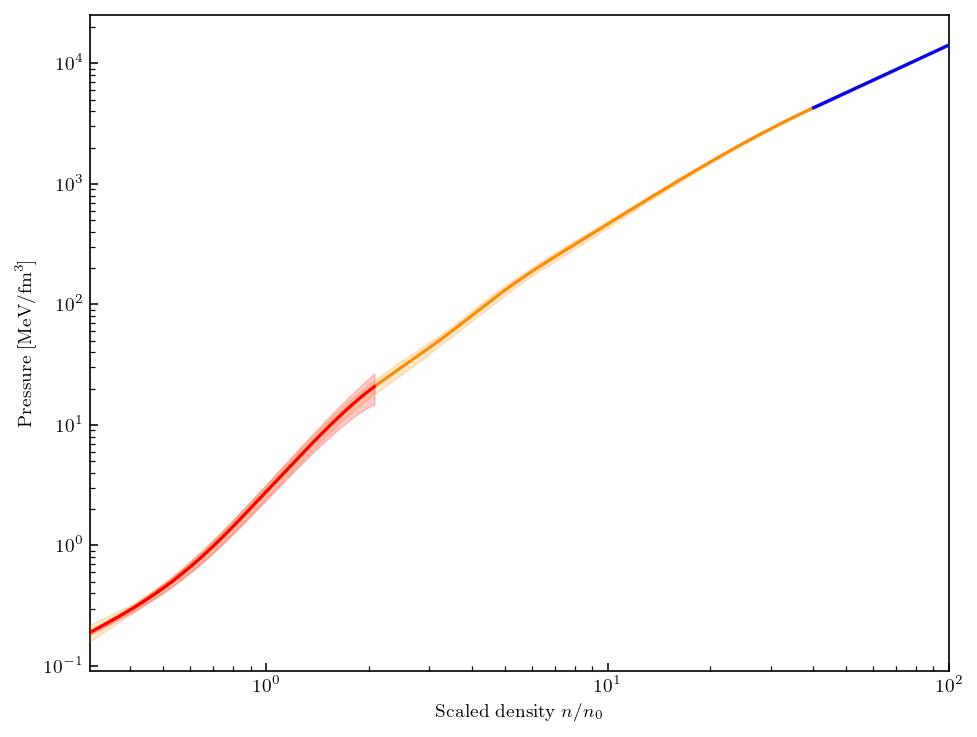

In [228]:
# plot the scaled result
plt.plot(n_xeft/n0, unscaled_chi_data, color='red', label=r'ChEFT (N3LO)', zorder=20)
plt.fill_between(n_xeft/n0, unscaled_chi_data-unscaled_chi_std, unscaled_chi_data+unscaled_chi_std, \
                alpha=0.2, color=color_xeft, zorder=20)
plt.plot(n_pqcd/n0, unscaled_pqcd_data, color='blue', label=r'pQCD (N2LO)', zorder=20)
plt.fill_between(n_pqcd/n0, unscaled_pqcd_data-unscaled_pqcd_std, unscaled_pqcd_data+unscaled_pqcd_std, \
                 alpha=0.2, color=color_pqcd, zorder=20)
plt.plot(X[:,0]/n0, unscaled_data_scaled, color='darkorange')
plt.fill_between(X[:,0]/n0, unscaled_data_scaled-unscaled_std, \
                 unscaled_data_scaled+unscaled_std, alpha=0.2, color='darkorange', zorder=10)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Scaled density $n/n_{0}$')
plt.ylabel(r'Pressure [MeV/fm$^{3}$]')
plt.xlim(min(density_test)/n0, 100.0)
#plt.ylim(0.0, 1.4)
plt.show()

---
---

In [229]:
# save mean function data to use with the zero mean function for comparison plot below!!!
# pressure_mean_function_0 = {
#     'dens': density_test,
#     'mean': y_pred_0_scaled,
#     'std': y_stdv_0,
#     'cp': cp_final,
#     'w': w_final
# }

# frg_mean_0_data = {
#     'dens': new_pts,
#     'mean': frg_mean,
#     'std': frg_std
# }

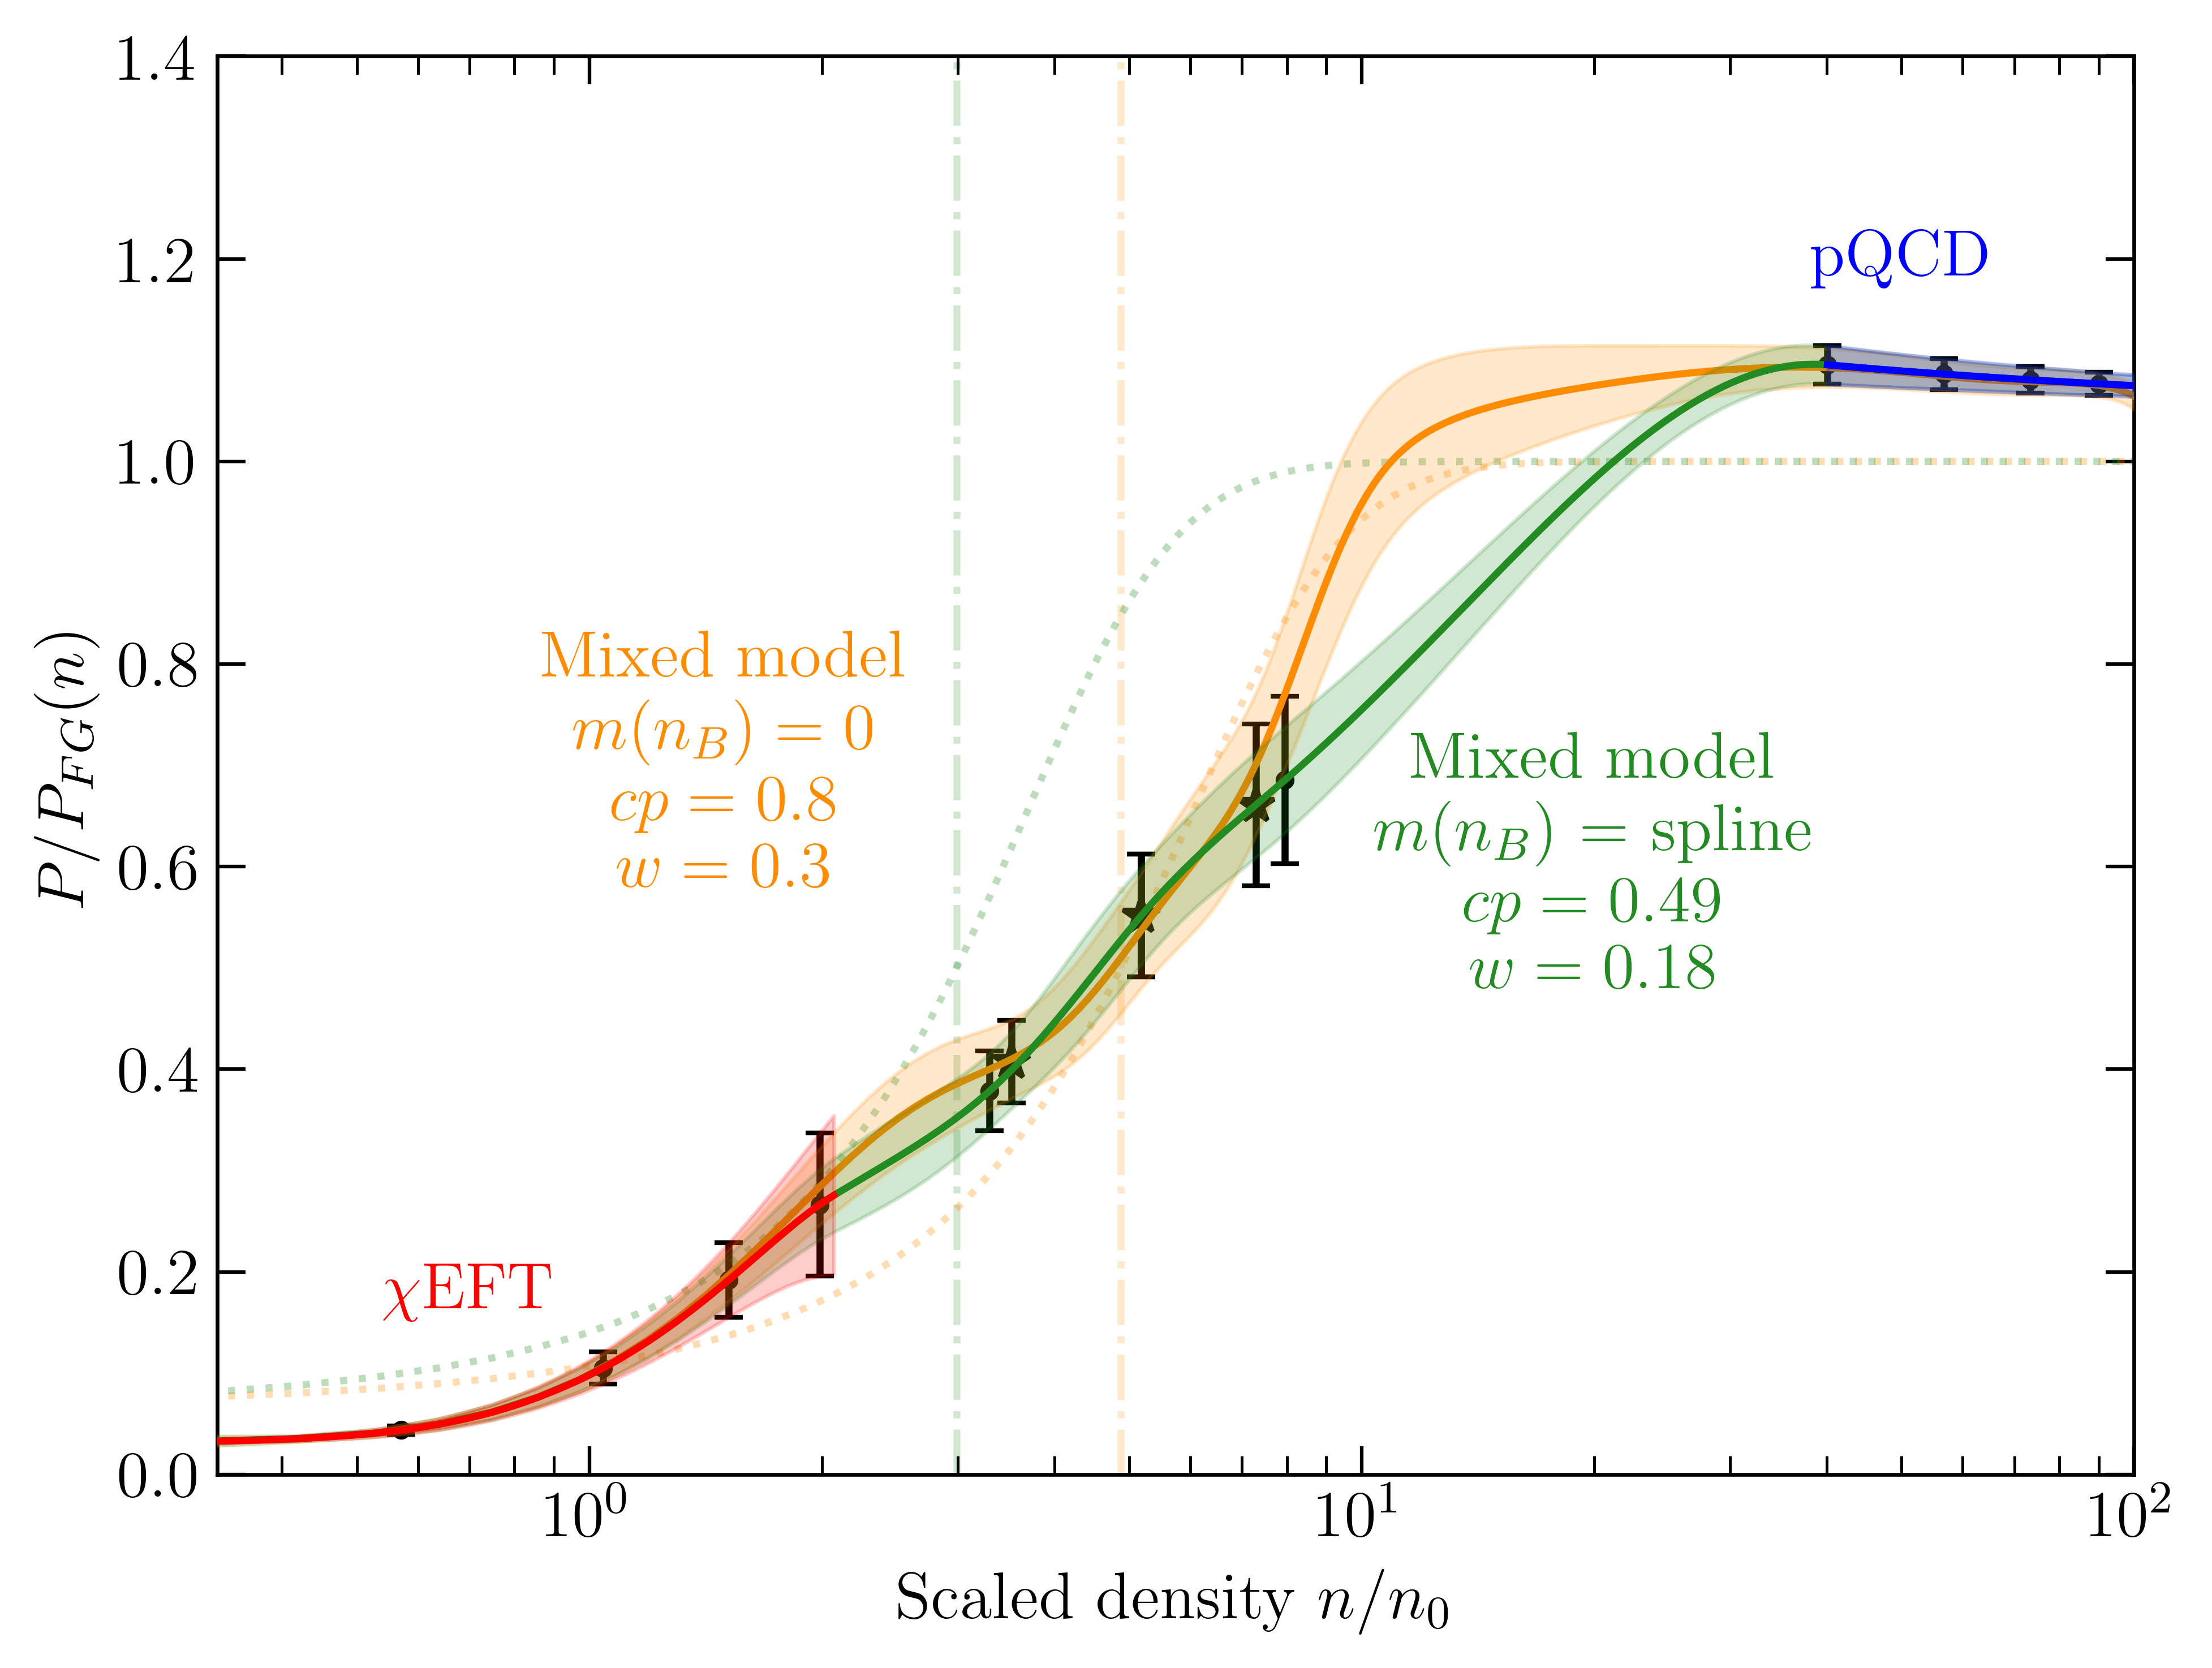

In [230]:
# plot the comparisons
fig, ax = plt.subplots(1,1, dpi=600)

# check the plotting of both of these together, see what they look like
ax.tick_params(which='major', labelsize=14, right=True, top=True, length=6)
ax.tick_params(which='minor', right=True, top=True, length=4)
ax.plot(n_xeft/n0, p_mean_xeft, color='red', zorder=10)
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft, zorder=9)
# ax.plot(density_test/n0, chi_predict, color=colors[2])
# ax.fill_between(density_test/n0, chi_predict-chi_std_predict, chi_predict+chi_std_predict, \
#                  color=colors[2], alpha=0.2)
ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', zorder=10)
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd, \
                zorder=9)
ax.errorbar(x=np.asarray(frg_mean_0_data['dens'])/n0, y=frg_mean_0_data['mean'], yerr=frg_mean_0_data['std'], \
            **errorbar_kwargs_2, label=r'$m(x) = spline$')
# ax.plot(density_test/n0, pqcd_predict, color=colors[2])
# ax.fill_between(density_test/n0, pqcd_predict-pqcd_std_predict, \
#                  pqcd_predict+pqcd_std_predict, color=colors[2], alpha=0.2)
ax.plot(X[:,0]/n0, y_pred_0_scaled, color='forestgreen', zorder=8)
ax.fill_between(X[:,0]/n0, y_pred_0_scaled-y_stdv_0, \
                 y_pred_0_scaled+y_stdv_0, alpha=0.2, color='forestgreen', zorder=7)
ax.plot(X[:,0]/n0, pressure_mean_function_0['mean'], color='darkorange', zorder=6)
ax.fill_between(X[:,0]/n0, pressure_mean_function_0['mean']-pressure_mean_function_0['std'], \
                 pressure_mean_function_0['mean']+pressure_mean_function_0['std'], alpha=0.2, \
                color='darkorange', zorder=5)

# FRG data sets
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_frg, label=r'$m(x) = 0$')

# some labelling for fun times
ax.text(0.7, 0.18, r'$\chi$EFT', va='center', ha='center', fontsize=14, color='red')
ax.text(50.0, 1.2, r'pQCD', va='center', ha='center', fontsize=14, color='blue')
ax.text(1.5, 0.7, r'''Mixed model
$m(n_B) = 0$
$cp = {}$
$w = {}$'''.format(pressure_mean_function_0['cp'], pressure_mean_function_0['w']), \
        va='center', ha='center', multialignment='center', fontsize=14, color='darkorange')
ax.text(20.0, 0.6, r'''Mixed model
$m(n_B)$ = spline
$cp = {}$
$w = {}$'''.format(cp_final, w_final), va='center', ha='center', \
        multialignment='center', fontsize=14, color='forestgreen')

# plot changepoints for visual aid
ax.axvline(x=pressure_mean_function_0['cp']/n0, linestyle='-.', color='darkorange', alpha=0.2, zorder=0)
ax.axvline(x=cp_final/n0, linestyle='-.', color='forestgreen', alpha=0.2, zorder=0)

# plot sigmoids
ax.plot(density_test/n0, \
        (1.0 / (1.0 + np.exp(-(density_test-pressure_mean_function_0['cp'])/pressure_mean_function_0['w']))),\
        color='darkorange', linestyle='dotted', alpha=0.3)
ax.plot(density_test/n0, (1.0 / (1.0 + np.exp(-(density_test-cp_final)/w_final))), color='forestgreen', \
       linestyle='dotted', alpha=0.3)

# other things
ax.set_xscale('log')
ax.set_xlabel('Scaled density $n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P/P_{FG}(n)$', fontsize=14)
ax.set_xlim(0.33, 100.0)
ax.set_ylim(0.0, 1.4)
fig.savefig('Mean_Functions/FRG_comparison_{}n0_zero_spline.png'.format(cutoff))
plt.show()

---
---

## Speed of sound calculation, $c_{s}^{2}(n)$

Let's now move on to our speed of sound calculation, to obtain the energy density and speed of sound squared, and hence have inputs for our TOV solver.

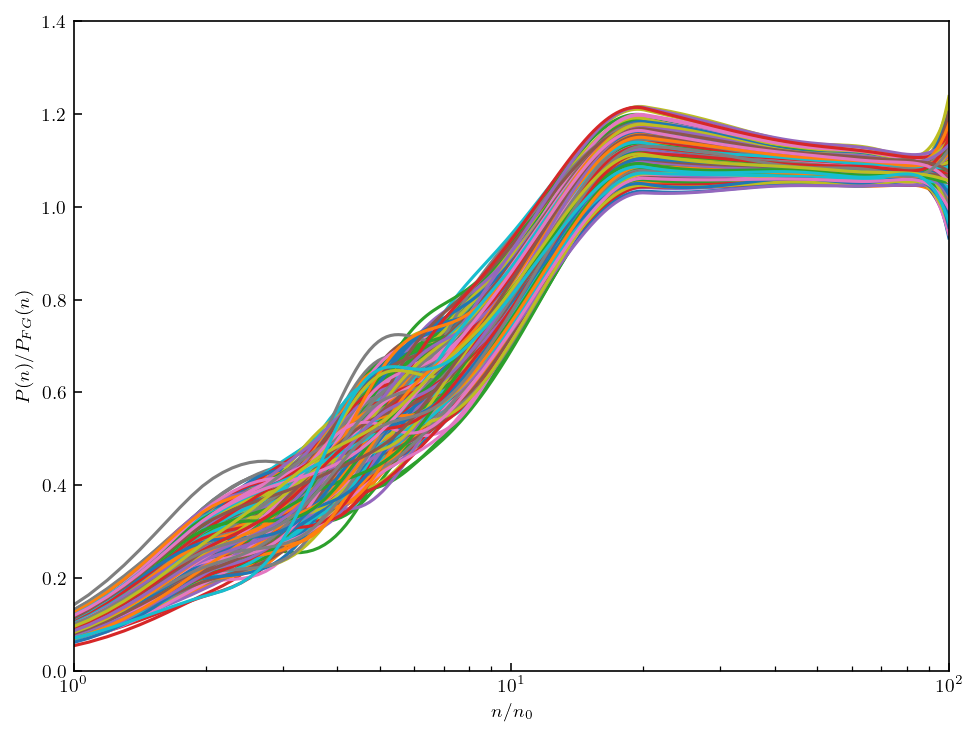

In [344]:
# sample from the pressure GP curve first
samples = 1000
samples_data_gp = gpcp.sample_y(X=density_test.reshape(-1,1), n_samples=samples)

if mean_function is True:
    mean_sample = np.zeros([len(density_test), samples])
    for i in range(samples):
        mean_sample[:,i] = y_pred_0_scaled
    samples_data = samples_data_gp + mean_sample
else:
    samples_data = samples_data_gp

# plot the samples to test the validity of the call
plt.plot(density_test/n0, samples_data)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.4)
plt.xscale('log')
plt.ylabel(r'$P(n)/P_{FG}(n)$')
plt.xlabel(r'$n/n_{0}$')
plt.show()

In [345]:
from eos_utils import cs2_routine, cs2_plots

# testing the function
gp_dict_full = {
    'dens': density_test,
    'mean': y_pred_0_scaled,
    'std_dev': y_stdv_0,
    'samples': samples_data,
    'true': None
}

pres_dict, edens_full, cs2_sampled = cs2_routine(gp_dict=gp_dict_full, sat_cut=0, plot=False)

print(cs2_sampled.keys())

Woo it is over!
dict_keys(['mean', 'std', 'samples'])


In [346]:
print(edens_full['samples'].shape)

(1000, 899)


In [347]:
# save the cs2 data for the plot
np.savez('cs2_20n0_{}_{}.npz'.format(number, mean_function), dens=density_test, mean=cs2_sampled['mean'], \
         std=cs2_sampled['std'], samples=cs2_sampled['samples'])

In [348]:
# check shapes
print(pres_dict['samples'].shape)
print(edens_full['samples'].shape)
print(cs2_sampled['samples'].shape)

(899, 1000)
(1000, 899)
(1000, 899)


In [349]:
# reduce to causal and stable stars
from tov_utils import causality_stability

cs2_reduced, edens_reduced, pres_reduced = causality_stability(cs2_sampled['samples'].T, \
                                                     edens_full['samples'].T, pres_dict['samples'])

In [350]:
presdict = {
    'dens': density_test,
    'samples': pres_reduced
}

In [351]:
print(edens_reduced.shape)
print(pres_reduced.shape)
print(cs2_reduced.shape)

(899, 973)
(899, 973)
(899, 973)


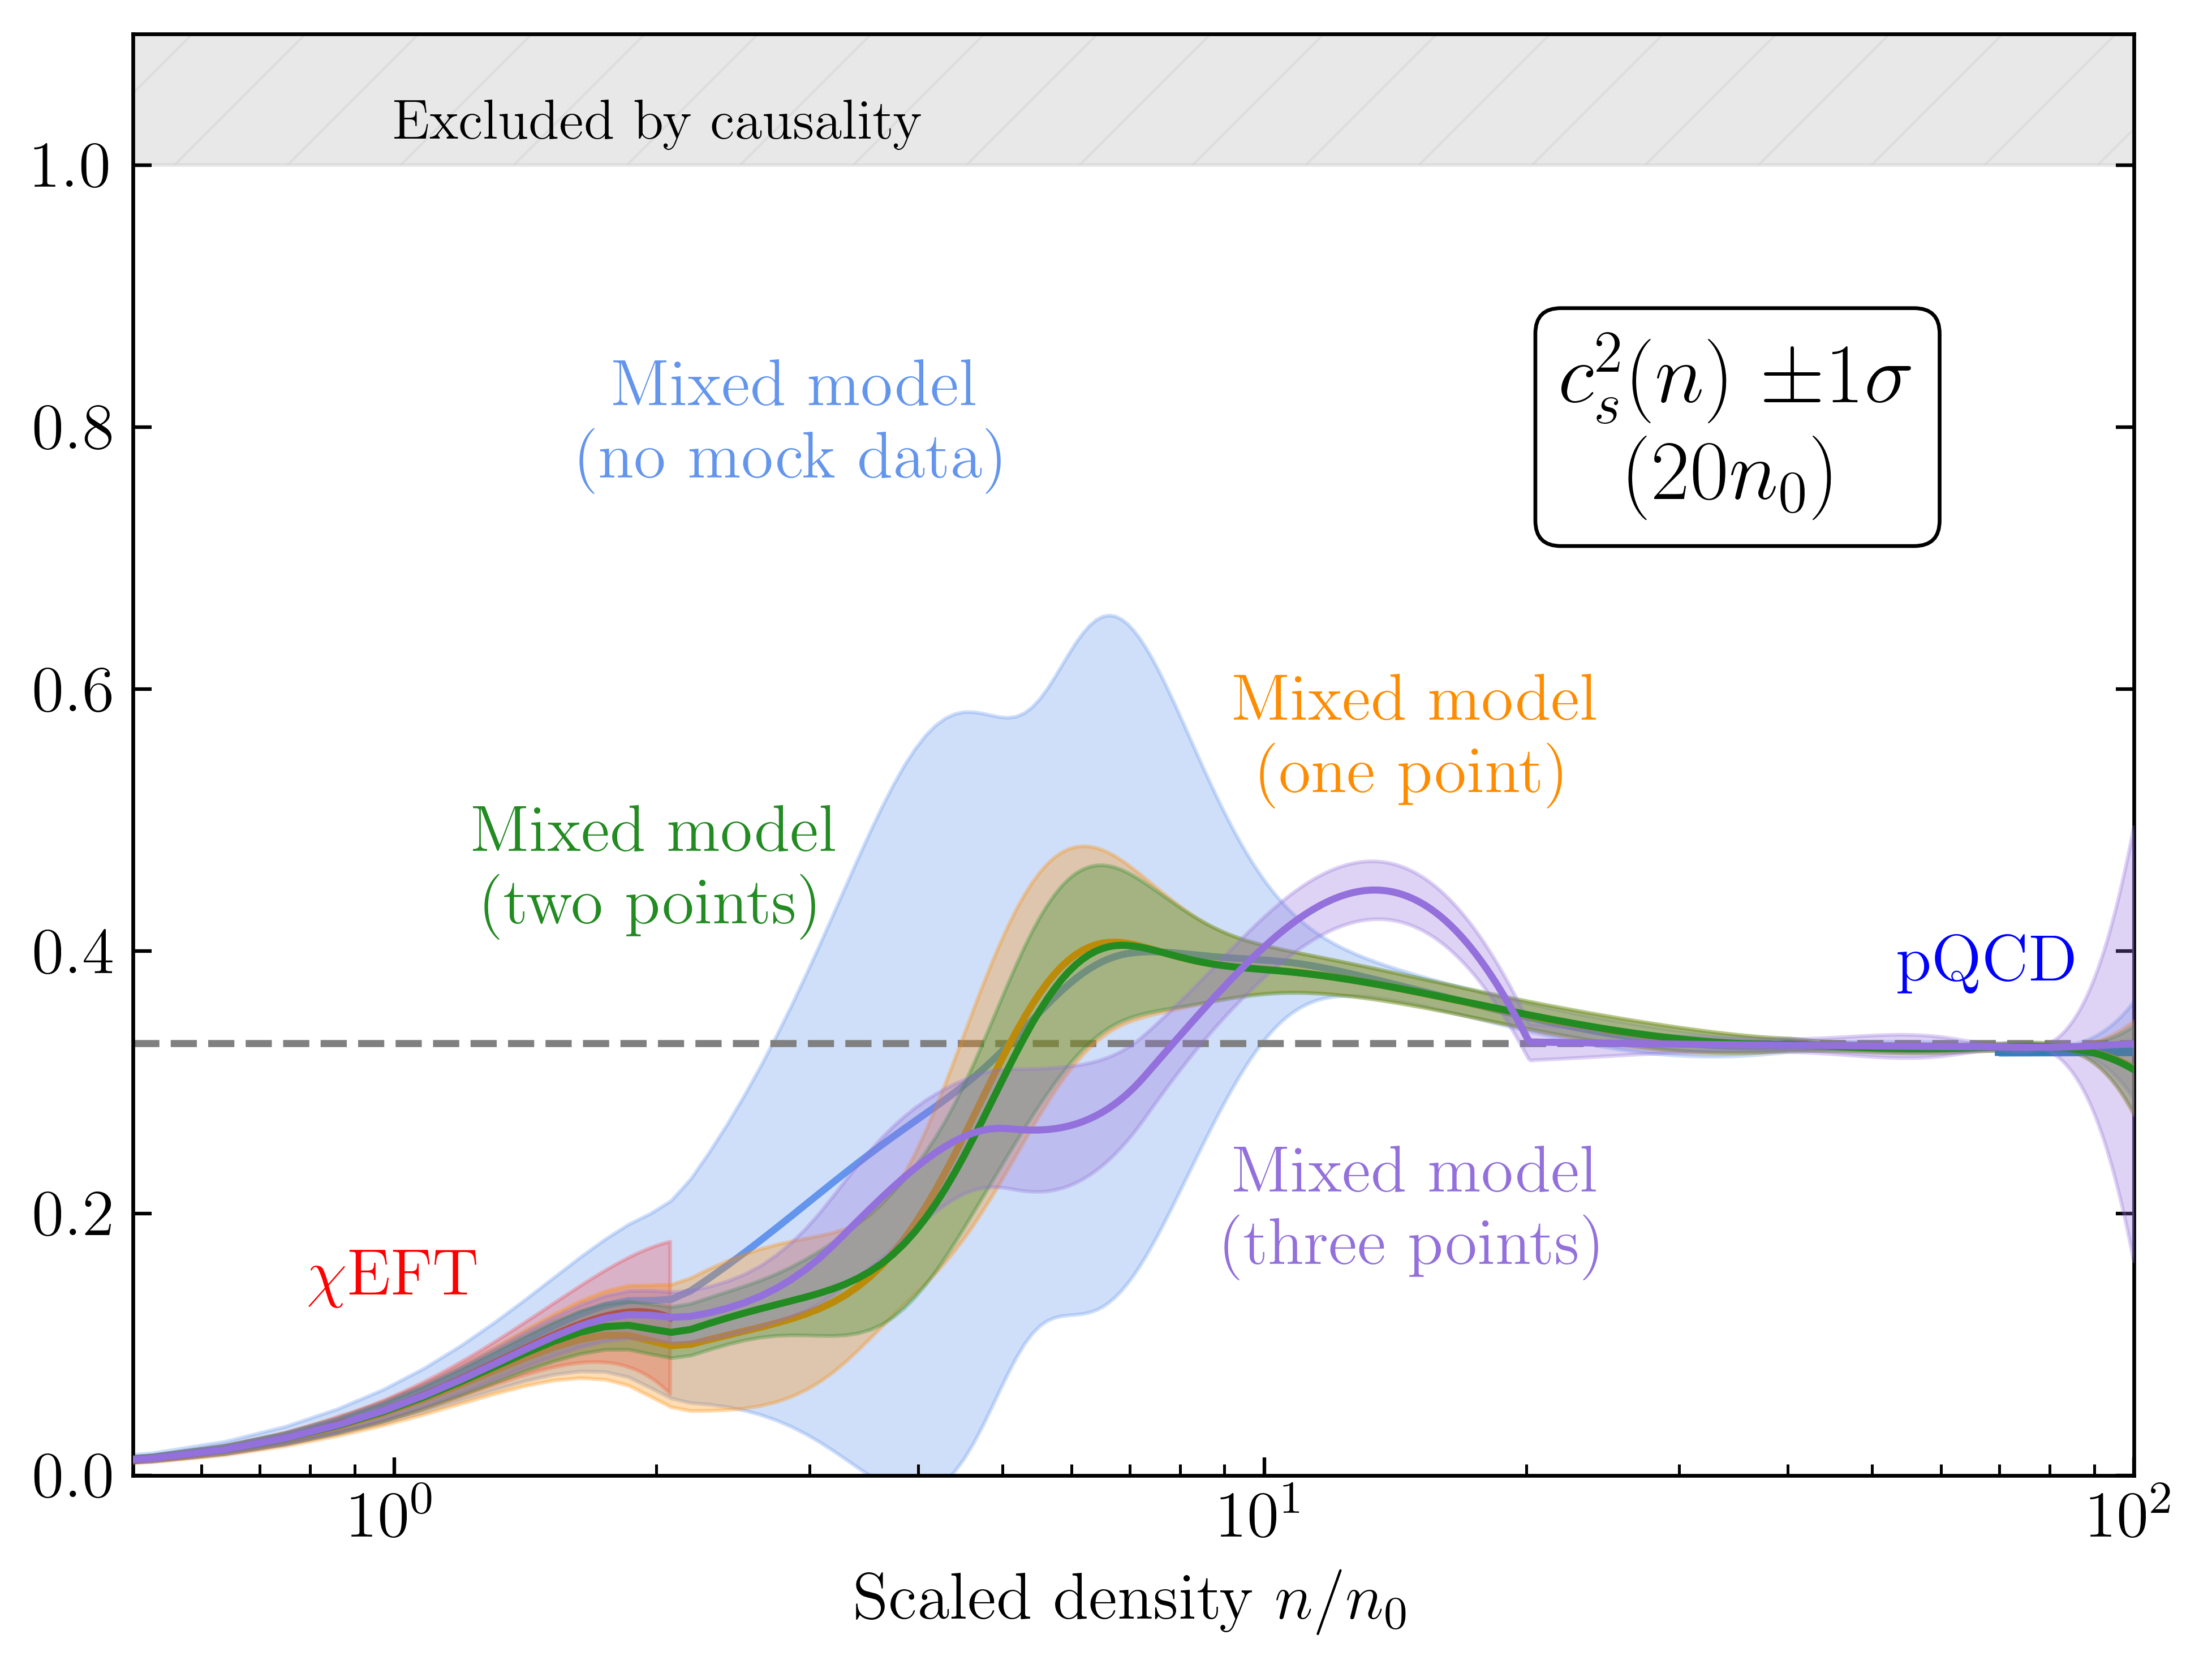

In [354]:
# plot the cs2 information
plt.figure(dpi=600)
plt.tick_params(axis='both', which='major', labelsize=14, right=True)
plt.tick_params(axis='both', which='minor', labelsize=14, right=True)

if mean_function is True:
    cs2_sampled0 = np.load('cs2_20n0_0_True.npz')
    cs2_sampled1 = np.load('cs2_20n0_1_True.npz')
    cs2_sampled2 = np.load('cs2_20n0_2_True.npz')
    cs2_sampled3 = np.load('cs2_20n0_3_True.npz')
else:
    cs2_sampled0 = np.load('cs2_20n0_no_mock_data.npz')
    cs2_sampled1 = np.load('cs2_20n0_one_pt.npz')
    cs2_sampled2 = np.load('cs2_20n0_two_pt.npz')
    cs2_sampled3 = np.load('cs2_20n0_three_pt.npz')

cs2_chiral = np.load('../data/NSM_data/cs2_chiral_NSM.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_NSM.npz')

# line for asymptotic limit
plt.axhline(y=0.33, linestyle='dashed', color='gray')

plt.plot(density_test/n0, cs2_sampled0['mean'], color='cornflowerblue', zorder=2)
plt.fill_between(density_test/n0, cs2_sampled0['mean']-cs2_sampled0['std'], \
                 cs2_sampled0['mean']+cs2_sampled0['std'], color='cornflowerblue', alpha=0.3, zorder=1)

# adding the mock data (one point)
plt.plot(density_test/n0, cs2_sampled1['mean'], color='darkorange', zorder=4)
plt.fill_between(density_test/n0, cs2_sampled1['mean']-cs2_sampled1['std'], \
                 cs2_sampled1['mean']+cs2_sampled1['std'], color='darkorange', alpha=0.3, zorder=3)

# adding the mock data (two points)
plt.plot(density_test/n0, cs2_sampled2['mean'], color='forestgreen', zorder=6)
plt.fill_between(density_test/n0, cs2_sampled2['mean']-cs2_sampled2['std'], \
                 cs2_sampled2['mean']+cs2_sampled2['std'], color='forestgreen', alpha=0.3, zorder=5)

# adding the mock data (three points)
plt.plot(density_test/n0, cs2_sampled3['mean'], color='mediumpurple', zorder=6)
plt.fill_between(density_test/n0, cs2_sampled3['mean']-cs2_sampled3['std'], \
                 cs2_sampled3['mean']+cs2_sampled3['std'], color='mediumpurple', alpha=0.3, zorder=5)

# chiral eft and pqcd data
plt.plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
plt.fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

plt.plot(cs2_chiral['density']/n0, cs2_chiral['mean'], color='red', label=r'ChEFT (N3LO)')
plt.fill_between(cs2_chiral['density']/n0, cs2_chiral['mean']-cs2_chiral['std'], \
                 cs2_chiral['mean']+cs2_chiral['std'], alpha=0.2, \
                color='red')

# exclude by causality
plt.fill_between(density_test/n0, 1.0*np.ones(len(density_test)), 1.1*np.ones(len(density_test)), \
                 color='lightgray', hatch='/', alpha=0.5)
plt.text(1.0, 1.02, r'Excluded by causality', fontsize=12)

plt.text(35.0, 0.8, r'''$c_{s}^{2}(n)$ $\pm 1\sigma$
($20n_{0}$)''', va='center', ha='center', \
         fontsize=18, bbox=dict(facecolor='w', boxstyle='round'))
plt.text(68.0, 0.39, r'''pQCD''', va='center', ha='center', fontsize=14, color='blue')
plt.text(1.0, 0.15, r'''$\chi$EFT''', va='center', ha='center', fontsize=14, color='red')
plt.text(2.9, 0.8, r'''Mixed model 
(no mock data)''', va='center', ha='center', fontsize=14, color='cornflowerblue')
plt.text(15.0, 0.56, r'''Mixed model 
(one point)''', va='center', ha='center', fontsize=14, color='darkorange')
plt.text(2.0, 0.46, r'''Mixed model 
(two points)''', va='center', ha='center', fontsize=14, color='forestgreen')
plt.text(15.0, 0.2, r'''Mixed model 
(three points)''', va='center', ha='center', fontsize=14, color='mediumpurple')
plt.xlim(0.5, 100.0)
plt.ylim(0.0, 1.1)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.xscale('log')
plt.savefig('overlay_cs2_20n0_changepoint_{}_{}.png'.format(number, mean_function))
plt.show()